# Building a customer segmentation models with Python

Customer segmentation and customer clustering are two **powerful techniques** used in marketing to better understand customers and tailor marketing strategies to their needs. In this project, we'll explore how to perform customer clustering with k-means in Python.

**Customer segmentation** is the process of dividing a customer base into smaller groups based on similar characteristics such as demographics, behavior, or purchase history. This approach helps marketers better understand their customers and design marketing strategies tailored to each segment.

**Clustering** is a machine learning technique that can be used for customer segmentation. K-means is a popular clustering algorithm that works by partitioning a dataset into k clusters, with each cluster represented by its centroid. The algorithm iteratively assigns each data point to the nearest cluster centroid until the algorithm converges and the cluster assignments stabilize.

![alt](https://images.unsplash.com/photo-1522543558187-768b6df7c25c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

We will use the data set provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail) "which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Many customers of the company are wholesalers." 

In [2]:
#Libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport
from sklearn.metrics import silhouette_score
import plotly.express as px

# E-Commerce Data

Let's dive into our data and gain a better understanding of it! We can achieve this by exporting the data and utilizing the powerful Pandas Profiling package. With Pandas Profiling, we can quickly and easily gain insights into our data, such as identifying missing values, detecting correlations between variables, and exploring descriptive statistics. With its intuitive and user-friendly interface, we can identify key patterns and trends in our data that may be missed through other methods. So, let's get started and use Pandas Profiling to discover the hidden gems in our data!

In [3]:
# Load data
online_retail_data_raw = pd.read_excel('datasets/Online Retail.xlsx')

In [4]:
# Profile Report
ProfileReport(online_retail_data_raw, title = 'E-Commerce dataset')

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


On the UCI website the variables are described as follows:

- <code> InvoiceNo </code> : The unique identifier of each customer invoice.
- <code>  StockCode  </code>: The unique identifier of each item in stock.
- <code> Description  </code>: The item purchased by the customer.
- <code> Quantity  </code>: The number of each item purchased by a customer in a single invoice.
- <code> InvoiceDate  </code>: The purchase date.
- <code> UnitPrice  </code>: Price of one unit of each item.
- <code> CustomerID  </code>: Unique identifier assigned to each user.
- <code> Country </code>: The country from where the purchase was made.

### Missing values
Thanks to the pandas profile report, we notice that **for 24.9 % of the values no <code> CustomerID </code> is assigned**, which makes this data unusable for segmentation purposes. We will discard these rows from our dataset for the moment and later on we will try to predict to which segment these customers would eventually belong

In [5]:
online_retail_data = online_retail_data_raw.dropna()
online_retail_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Duplicate
The pandas profiling report also indicates a problem of duplicated lines, we will also delete this one from our data set. 

In [6]:
print("The dataset counts {0:.0f} duplicated rows".format(online_retail_data.duplicated().sum()))

The dataset counts 5225 duplicated rows


In [7]:
# Get rid of duplicates
online_retail_data.drop_duplicates()

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[401604 rows x 8 columns]

### Canceled Orders & Returns

The report points to negative values in the quantity and price columns. This is related to returned purchases by customers or simply cancelled orders. We will also discard these rows for our future analysis

In [8]:
# Detect the canceled invoice
online_retail_data['InvoiceNo'] = online_retail_data['InvoiceNo'].astype(str)
mask = online_retail_data.InvoiceNo.str.startswith('C')
# Make a copy of your cancellation columns:
canceled_invoice_data = online_retail_data[mask].copy()

/var/folders/1r/7t449kpd1x144fxb4054tp700000gn/T/ipykernel_3293/1013459918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retail_data['InvoiceNo'] = online_retail_data['InvoiceNo'].astype(str)


In [9]:
# Turn the negative values to positives
cols = ['Quantity']
canceled_invoice_data[cols] = canceled_invoice_data[cols].mul(-1)

# Get rid of the Invoice Number and date
drop_cols = ['InvoiceNo', 'InvoiceDate']
canceled_invoice_data = canceled_invoice_data.drop(columns=drop_cols)

# Save the columns names
op_cols = canceled_invoice_data.columns.tolist()

In [10]:
# Drop all the canceled invoice:
online_retail_data = online_retail_data[~mask]
len(online_retail_data)

397924

In [11]:
# Isolate the matching lines in the original data frame
to_drop = online_retail_data.reset_index().merge(canceled_invoice_data, how='inner').set_index('index')
groups = to_drop.sort_values('InvoiceDate').groupby(op_cols)

# List of indices to drop
dropme = [] 
# 1. Where there's only one match, add them to the drop list.
dropme.extend(groups.filter(lambda x: len(x)==1)
                    .index
                    .tolist())
# 2. Where there are multiple matches, Add the oldest to the drop list.
dropme.extend(groups.filter(lambda x: len(x)>1)
                    .sort_values('InvoiceDate')
                    .drop_duplicates(op_cols, keep='first')
                    .index
                    .tolist())

In [12]:
# Drop from the original dataframe
online_retail_data = online_retail_data.drop(dropme)
len(online_retail_data)

394953

# Prepocessing for Modeling

To better understand our customers, we will use their purchase data to establish their **RFM scores**. However, this requires us to manipulate and transform our dataset. RFM is a powerful technique that is widely used in marketing to segment customers based on their past purchasing behavior.

RFM stands for Recency, Frequency, and Monetary Value. 
- **Recency** is a measure of how recently a customer made a purchase
- **Frequency** is the number of times they made a purchase
- **Monetary Value** is the total amount of money they spent. By combining these three factors, we can create a score for each customer that represents their overall value to our business.

### Recency

We are going to assign to each customer a recency score. For that we are going to look for the date of their first purchase on the website. A low score indicates that it is a long time customer where a high score shows that it is a rather recent customer.

In [13]:
# Keep only the most recent date of purchase
online_retail_data['rank'] = online_retail_data.sort_values(['CustomerID','InvoiceDate']).groupby(['CustomerID'])['InvoiceDate'].rank(method='min').astype(int)
df_rec = online_retail_data[online_retail_data['rank']==1]

# Calculate the date difference
df_rec['recency'] = (df_rec['InvoiceDate'] - pd.to_datetime(min(df_rec['InvoiceDate']))).dt.days
df_rec

/var/folders/1r/7t449kpd1x144fxb4054tp700000gn/T/ipykernel_3293/1993895020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['InvoiceDate'] - pd.to_datetime(min(df_rec['InvoiceDate']))).dt.days


InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541801    581578     22993         SET OF 4 PANTRY JELLY MOULDS        12   
541802    581578     22907     PACK OF 20 NAPKINS PANTRY DESIGN        12   
541803    581578     22908        PACK OF 20 NAPKINS RED APPLES        12   
541804    581578     23215     JINGLE BELL HEART ANTIQUE SILVER        12   
541805    581578     22736          RIBBON REEL MAKING SNOWMEN         10   

               InvoiceDate  UnitPrice  CustomerID         Country  rank  \
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom     1   
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     1   
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom     1   
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     1   
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     1   
...                    ...        ...         ...             ...   ...   
541801 2011-12-09 12:16:00       1.25     12713.0         Germany     1   
541802 2011-12-09 12:16:00       0.85     12713.0         Germany     1   
541803 2011-12-09 12:16:00       0.85     12713.0         Germany     1   
541804 2011-12-09 12:16:00       2.08     12713.0         Germany     1   
541805 2011-12-09 12:16:00       1.65     12713.0         Germany     1   

        recency  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
541801      373  
541802      373  
541803      373  
541804      373  
541805      373  

[103271 rows x 10 columns]

### Frequency

In the same way we will assign a score to each customer according to their frequency of purchase in the store. for that we will count for each customer the number of purchase made then classify them. in the same way **the more a customer bought** at this merchant **the higher his score** will be. 

In [14]:
# Count number of purchase per customer
freq = df_rec.groupby('CustomerID')['InvoiceDate'].count()

# Create a new dataframe to store the info 
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

# Merge it with the recency dataframe
rec_freq = df_freq.merge(df_rec,on='CustomerID')
rec_freq

CustomerID  frequency InvoiceNo StockCode  \
0          12347.0         31    537626     85116   
1          12347.0         31    537626     22375   
2          12347.0         31    537626     71477   
3          12347.0         31    537626     22492   
4          12347.0         31    537626     22771   
...            ...        ...       ...       ...   
103266     18287.0         29    554065    85040A   
103267     18287.0         29    554065    85039B   
103268     18287.0         29    554065    85039B   
103269     18287.0         29    554065    85040A   
103270     18287.0         29    554065    72349B   

                                Description  Quantity         InvoiceDate  \
0           BLACK CANDELABRA T-LIGHT HOLDER        12 2010-12-07 14:57:00   
1         AIRLINE BAG VINTAGE JET SET BROWN         4 2010-12-07 14:57:00   
2         COLOUR GLASS. STAR T-LIGHT HOLDER        12 2010-12-07 14:57:00   
3                   MINI PAINT SET VINTAGE         36 2010-12-07 14:57:00   
4       CLEAR DRAWER KNOB ACRYLIC EDWARDIAN        12 2010-12-07 14:57:00   
...                                     ...       ...                 ...   
103266      S/4 PINK FLOWER CANDLES IN BOWL        36 2011-05-22 10:39:00   
103267   S/4 IVORY MINI ROSE CANDLE IN BOWL        60 2011-05-22 10:39:00   
103268   S/4 IVORY MINI ROSE CANDLE IN BOWL        12 2011-05-22 10:39:00   
103269      S/4 PINK FLOWER CANDLES IN BOWL        12 2011-05-22 10:39:00   
103270      SET/6 PURPLE BUTTERFLY T-LIGHTS        12 2011-05-22 10:39:00   

        UnitPrice         Country  rank  recency  
0            2.10         Iceland     1        6  
1            4.25         Iceland     1        6  
2            3.25         Iceland     1        6  
3            0.65         Iceland     1        6  
4            1.25         Iceland     1        6  
...           ...             ...   ...      ...  
103266       1.65  United Kingdom     1      172  
103267       1.45  United Kingdom     1      172  
103268       1.65  United Kingdom     1      172  
103269       1.65  United Kingdom     1      172  
103270       2.10  United Kingdom     1      172  

[103271 rows x 11 columns]

### Monetary Values 

Finally, we are interested in the customers' spending on the site. We calculate for each one their total expenditure since they use this website.

In [15]:
# Calculate the total spend per customer 
rec_freq['total'] = rec_freq['Quantity']*online_retail_data['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()

# Store it in a new dataframe
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [16]:
#Merge it with the recency and frequency dataframe
rfm = m.merge(rec_freq,on='CustomerID')

#Keep the columns we are interested in
customer_rfm = rfm[['recency','frequency','monetary_value']]
print(customer_rfm.shape)

(103271, 3)


We can use a box plot to visualize the initial results of our RFM analysis. The box plot is a useful tool for summarizing the distribution of our RFM scores and identifying outliers!

Text(0.5, 1.02, 'Summary Statistics For Each Category Based On The Campaign')

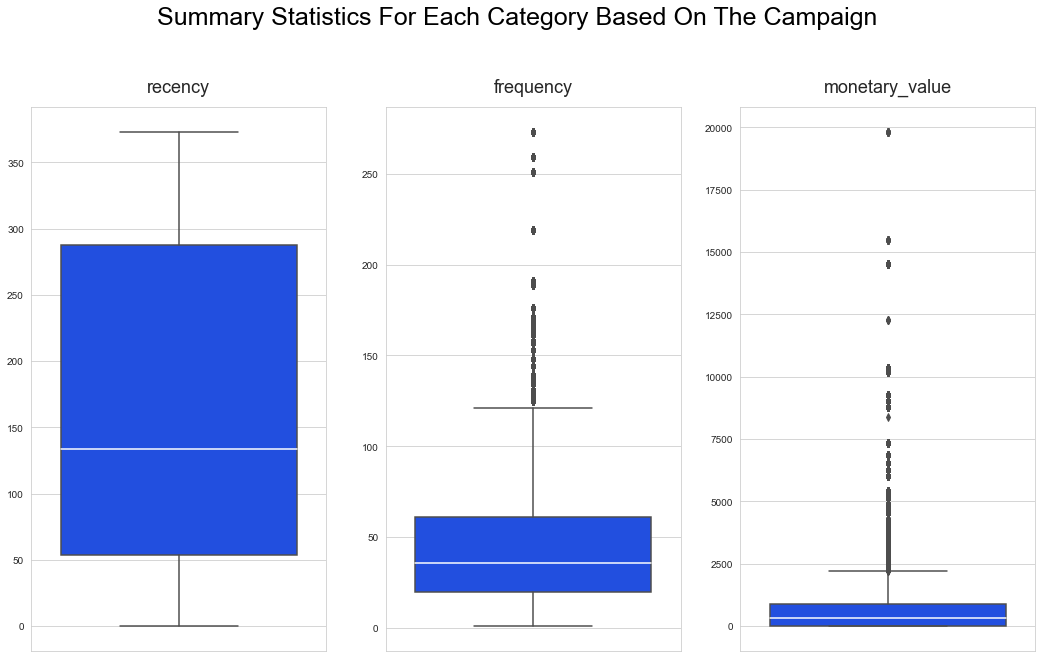

In [17]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,3, figsize=(18,10), sharex=False)

#Plot for each categories a new boxplot
for i, col in enumerate(list(customer_rfm.columns.values)): 
    sns.boxplot(y= col, 
                data = customer_rfm, 
                ax= ax[i], 
                palette=sns.color_palette('bright'), 
                medianprops=dict(color="white", alpha=1)) 
    
    ax[i].set_title(col, fontsize=18, pad=15)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    

plt.subplots_adjust(hspace = 0.5, wspace=0.2)
fig.suptitle("Summary Statistics For Each Category Based On The Campaign", fontsize=25, color="k", y=1.02)

## Outliers 

Based on the findings from our box plot analysis, it appears that there are many outliers for both <code>frequency</code> and <code>monetary_value </code>. To improve the accuracy of our RFM analysis, it is important to remove these outliers from our dataset.

Outliers can have a significant impact on our data analysis, particularly when it comes to customer segmentation and clustering. Outliers are data points that **fall significantly outside the normal range of values** for a particular variable. They can be caused by a variety of factors, such as data entry errors or unusual customer behavior.

One effective method for identifying and dealing with outliers is the **interquartile range (IQR) method**. The IQR method is based on the distribution of values within a dataset and involves identifying the middle 50% of data points. The IQR is the range between the 25th and 75th percentile of data points, and any values that fall outside of this range are considered outliers.

In [18]:
#Find Q1, Q3, and interquartile range for each column
Q1 = customer_rfm.quantile(q=.25)
Q3 = customer_rfm.quantile(q=.75)
IQR = customer_rfm.apply(stats.iqr)

#Only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
customer_rfm_clean = customer_rfm[~((customer_rfm < (Q1-1.5*IQR)) | (customer_rfm > (Q3+1.5*IQR))).any(axis=1)]

#Find how many rows are left in the dataframe 
print(customer_rfm_clean.shape)

(93132, 3)


## Normalization

Normalization is an important step in data preprocessing that is often necessary for machine learning and data analysis. It involves transforming data values to a standard range, typically between 0 and 1, in order to ensure that all variables are treated equally in subsequent analysis.

One popular normalization technique is the Minmaxscaler, which is a scaling method that transforms values to a range between 0 and 1 based on the minimum and maximum values of each variable. This method is effective for normalizing data that has a linear distribution.

By normalizing our data with Minmaxscaler, we can **eliminate the impact of varying scales on the results of our analysis**. 

In [19]:
# Fit the data
scaler = MinMaxScaler().fit(customer_rfm_clean)

#Transform 
features = scaler.transform(customer_rfm_clean)

# Turn into a dataframe 
scaled_features = pd.DataFrame(features, columns = customer_rfm_clean.columns)

We now have cleaned and normalized data. We can now use it to train our model! 

# K-Means

K-means is a popular clustering algorithm used in machine learning and data science. It involves **grouping similar data points together based on their distance from a centroid**, which is a central point that represents the average of all the points in a given cluster. One challenge with the k-means algorithm is that it requires a pre-specified number of clusters, which can be difficult to determine.

Tuning a k-means algorithm is an important step in the process of customer clustering, as it allows us to identify the optimal number of clusters for our data. One effective way to do this is to use the elbow method and WSS (Within-Cluster-Sum-of-Squares) to determine the ideal number of clusters.

The elbow method involves plotting the WSS against the number of clusters and identifying the "elbow" point, where the decrease in WSS begins to level off. This point represents the optimal number of clusters for the data, as it balances the trade-off between minimizing WSS and avoiding overfitting.

WSS, on the other hand, measures the compactness of clusters, which is the sum of squared distances between each point and the centroid of its assigned cluster. By minimizing WSS, we ensure that each cluster is well-defined and representative of the underlying data.

Once we have identified the optimal number of clusters, we can fine-tune the k-means algorithm to ensure that it is producing accurate and reliable results. This may involve adjusting the number of initializations, the convergence criteria, or the distance metric used to measure similarity between data points.

In [20]:
# Initiate a list of WSS scores
wcss = []

# Itterate 
for i in range(1,11):
    kmeans= KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(scaled_features) #Finds the Kmeans to our data
    wcss.append(kmeans.inertia_)

<function matplotlib.pyplot.show(close=None, block=None)>

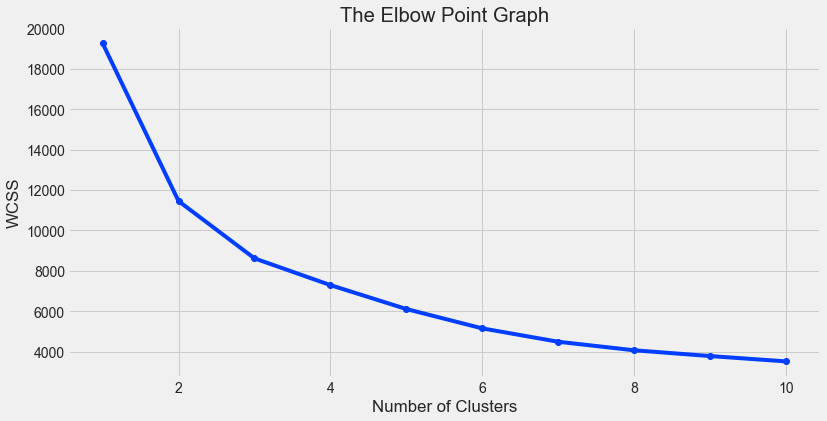

In [21]:
# Plot the elbow point graph
plt.style.use('fivethirtyeight')
plt.figure(figsize = (12,6))

plt.plot(range(1,11),wcss, color=sns.color_palette('bright')[0], marker='o')

plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show

We observe a clear decline of the curve after 3 clusters, so we estimate that the optimal number of clusters for our K-means model is 3 . 

In [22]:
# Instantiate and fit the model 
kmeans = KMeans( n_clusters = 3, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [23]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.3904565067225761


We computed the silhouette_score of our model. The silhouette score is a metric used to evaluate the quality of a clustering solution. It measures how similar a data point is to other points in its own cluster compared to points in neighboring clusters. The silhouette score ranges from -1 to 1, with a score of 1 indicating a very good clustering solution, and a score of -1 indicating a very poor one.
Our score is 0.4 which means we have a pretty good clustering algorithm. 

# Interpretaion and visualization

How does our solution segment customers? Let's find out now !

In [55]:
# Predict the cluster
pred = kmeans.predict(scaled_features)

# Create a dataframe with the cluster number per customer
frame = pd.DataFrame(customer_rfm_clean)
frame['cluster'] = pred
frame

recency  frequency  monetary_value  cluster
0             6         31         1393.01        2
1             6         31         1393.01        2
2             6         31         1393.01        2
3             6         31         1393.01        2
4             6         31         1393.01        2
...         ...        ...             ...      ...
103266      172         29         1028.64        2
103267      172         29         1028.64        2
103268      172         29         1028.64        2
103269      172         29         1028.64        2
103270      172         29         1028.64        2

[93132 rows x 4 columns]

In [25]:
# plot 3D representation of the clusters

#Turn cluster into a categorical variable 
frame2 = frame.copy()
frame2['cluster'] = frame2['cluster'].astype('str')

df = px.data.iris()
fig = px.scatter_3d(frame2, x='recency', y='frequency', z='monetary_value',
              color='cluster',  symbol='cluster', size_max=1, opacity = 0.5)

# Make the plot wider
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0))     
fig.update_traces(marker_size = 4)         
fig.show()

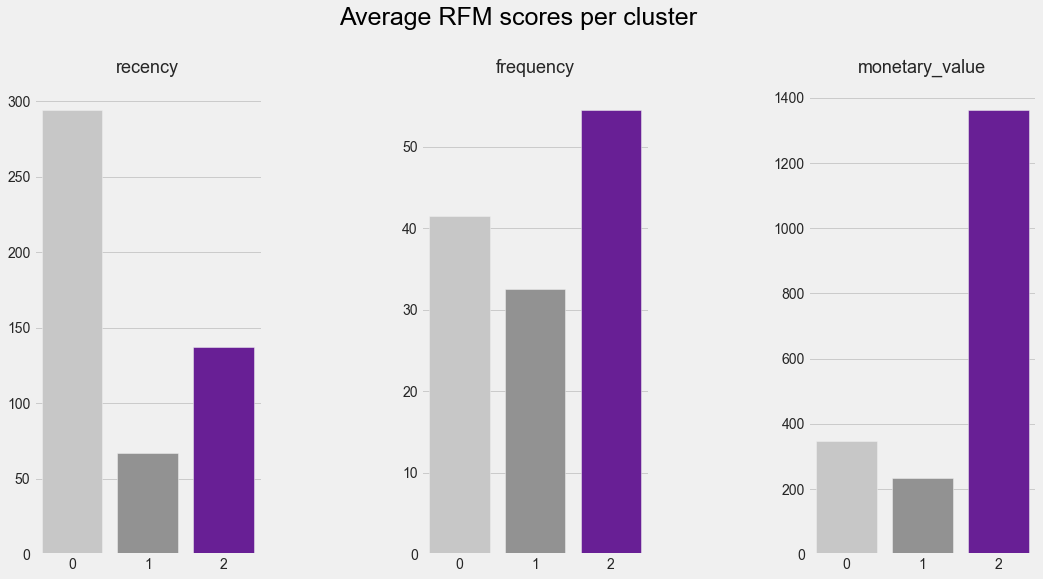

In [68]:
# compute the average behavior per cluster
avg_df = frame.groupby(['cluster'], as_index=False).mean()

#Barplot
fig, ax = plt.subplots(1,3, figsize=(16,8), sharex=True)

for i, col in enumerate(['recency', 'frequency', 'monetary_value']): 
    sns.barplot(x='cluster',y=str(col),data=avg_df, ax=ax[i],  palette=colors)
    ax[i].set_title(col, fontsize=18, pad=15)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    

plt.subplots_adjust(hspace = 0.5, wspace=0.7)
fig.suptitle("Average RFM scores per cluster", fontsize=25, color="k", y=1.02)
plt.show() 

Based on the previous graphs, we can observe distinct patterns among the groups detected by our clustering solution.

- **Cluster 0** represents the group of very recent customers who purchase items frequently but spend relatively small amounts per purchase.

- **Cluster 1** comprises the older customers of the website who make purchases less frequently and spend relatively little in terms of monetary value.

- **Cluster 2** includes customers who are rather familiar with the business, it's a group of frequent buyers who spend large amounts on their purchases.

These distinct customer behaviors are valuable insights that can be used to develop targeted marketing strategies and tailor product offerings to different segments.
We understand that the group of interest for our business is cluster 2. How many customers are in this group? Let's plot a pie chart with the percentage of client in each group. 


In [53]:
# Compute percentage per cluster 
cluster_count = frame.groupby('cluster')['cluster'].count()
cluster_count_perc = pd.concat([cluster_count, 
               cluster_count / cluster_count.sum()] , keys=('counts','percentage'), axis=1)
cluster_count_perc

counts  percentage
cluster                    
0         33071    0.355098
1         44671    0.479653
2         15390    0.165249

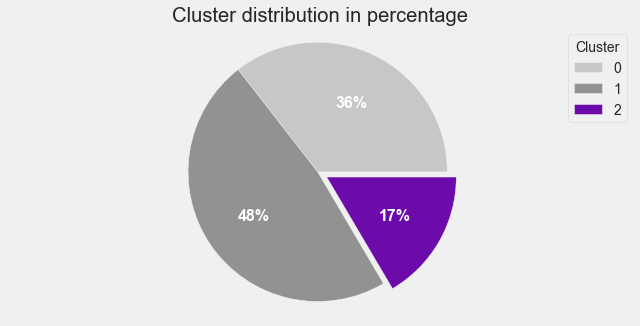

In [54]:
# Pie plot
plt.rcParams['figure.figsize'] = [10, 5]
colors = ['#C7C7C7', '#929292', '#6C0BA9']

labels = cluster_count_perc.index

fig1, ax1 = plt.subplots()
ax1.pie(cluster_count_perc.percentage, 
        colors = colors, 
        autopct='%.0f%%', #number format 
        textprops={'fontsize': 16, 'color':'white', 'fontweight':'bold'}, #aesthetic for text
        explode = (0.00, 0.00, 0.08))

ax1.axis('equal')
plt.title('Cluster distribution in percentage')
plt.legend(labels, loc='best', title='Cluster')
plt.show()

## Conclusion 

From a strategic perspective, **focusing on Cluster 2**, which represents 17% of the customer base, could be highly beneficial for the business. According to the Pareto principle, this group of customers may be responsible for a disproportionate amount of the business's revenue, and therefore warranting extra attention.

Additionally, coupling this clustering information with another database containing clients' personal information, such as demographics, purchase history, and behavioral patterns, could provide further insights into how to effectively target and retain this group of high-value customers. This could allow the business to tailor marketing strategies and promotions to specific customer segments, thereby increasing engagement and loyalty.

By understanding the unique needs and behaviors of these customers, the business can offer tailored promotions and recommendations, which can help build customer loyalty and increase revenue over time. Overall, strategically focusing on high-value customer segments like Cluster 2 and using additional customer data to inform business decisions can have a significant impact on the success and growth of the business.